# Deep Q Learning

![alt text](https://drive.google.com/uc?id=1fTvibi4u_K4i-4sypet61A8ZBfswXzXN)



In [0]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from collections import deque
from keras import Sequential, models
from keras import losses
from keras.layers import Dense
from keras.optimizers import adam
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

Using TensorFlow backend.


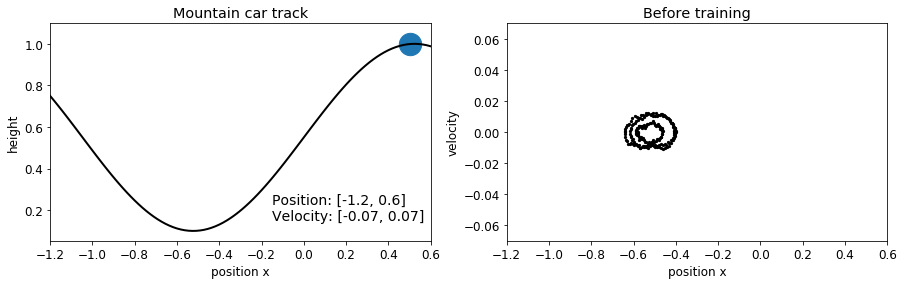

In [0]:
"""
Introduction of environment 
"""

fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (15, 4))

# Figure 1 - the environment of the moutaincar
x = np.linspace(-1.2,0.6,100)
ax0.plot(x, np.sin(3 * x) * 0.45 + 0.55, 'k-', lw = 2)
ax0.scatter(0.5, 1, s = 500)
ax0.set_title('Mountain car track')
ax0.set_xlabel('position x')
ax0.set_ylabel('height')
ax0.set_xlim(-1.2, 0.6)

# Insert text
env = gym.make('MountainCar-v0')
space_low = env.observation_space.low
space_high = env.observation_space.high
pos = [space_low[0], space_high[0]]
vel = [space_low[1], space_high[1]]
ax0.text(-0.15, 0.15, 'Position: %s \nVelocity: %s' % (pos, vel), fontsize = 14)

# Figure 2 - the result from a series of random actions
def random_actions(): # Get data from a series random actions
    observation = env.reset()
    pos, vel = [], []
    env.seed(0)
    env.reset()
    for timestamp in range(200):
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        pos.append(observation[0])
        vel.append(observation[1])
    return pos, vel

pos, vel = random_actions()
ax1.scatter(pos, vel, color = 'k', s = 5)
ax1.set_title('Before training')
ax1.set_xlabel('position x')
ax1.set_ylabel('velocity')
ax1.set_xlim(-1.2, 0.6)
ax1.set_ylim(-0.07, 0.07)
env.close()

In [0]:
class DQN():

    """ Implementation of deep q learning algorithm"""

    def __init__(self):

        """
        Initalize hyperparameters
        """

        self.action_space = env.action_space.n
        self.state_space = env.observation_space.shape[0]
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.discount_factor = 0.98
        self.learning_rate = 0.0005
        self.batch_size = 64
        self.memory = deque(maxlen =  10000)
        self.model = self.build_model()

    def build_model(self):

        """
        The model is based on a simple neural network. The model is trying to predict 
        the return of reward by taking an action given the state of the current environment.
        """

        model = Sequential()
        model.add(Dense(48, input_shape = (self.state_space,), activation = 'relu'))
        model.add(Dense(48, activation = 'relu'))
        model.add(Dense(self.action_space, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = adam(lr = self.learning_rate))
        return model

    def save_model(self, filename = None):

        self.model.save(filename)

    def act(self, state):

        """
        To balance between exploration and exploitation, a epsilon-greedy policy is 
        introduced. It is a decaying probability, which the learning algorithm
        uses to choose between picking random action (exploration) or greedy action 
        based on existing knowledge (exploitation).
        """
        
        if random.uniform(0, 1) <= self.epsilon: # exploration
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state) # exploitation
            return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):

        """
        Memroy collection. Save the memory that the agent observes and we will 
        use this data later
        """ 

        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        
        """
        Agent experiences replay memory during training. Replay memory will be 
        selected randomly, so that a batch of tranining samples are decorrelted. 
        """
      
        # Wait until we have enough sample available in memeory
        if len(self.memory) < self.batch_size: 
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # Q function is updated based on Bellman Equation
        states, next_states = np.squeeze(states), np.squeeze(next_states)
        targets = rewards + self.discount_factor * (np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets 

        self.model.fit(states, targets_full, epochs = 1, verbose = 0)

    def total_energy(self, state):

        """
        We will use total energy to guide the agent so that even small victories could 
        have effects on learning. Total energy is the sum of its motion (i.e. kinetic energy) 
        and stored energy of position (i.e. potential energy).
        """
        
        x = state[0, 0] # position in x direction
        v = state[0, 1] # velocity

        # Based on the OpenAI environment, height equals to sin(3x) * 0.45 + 0.55
        potential_energy = math.sin(3 * x) * 0.45 + 0.55
        kinetic_energy = 0.5 * (v ** 2)

        return potential_energy + kinetic_energy

    def optimal_reward(self, next_state, state):

        """
        The agent is given a reward based on how much energy it has gain afer an action.
        The reward is scaled to a range around {-1, 1}
        """

        return 100 * (self.total_energy(next_state) - self.total_energy(state))

episode: 0/500, score: -200
episode: 1/500, score: -200
episode: 2/500, score: -200
episode: 3/500, score: -200
episode: 4/500, score: -200
episode: 5/500, score: -200
episode: 6/500, score: -200
episode: 7/500, score: -200
episode: 8/500, score: -200
episode: 9/500, score: -200
episode: 10/500, score: -200
episode: 11/500, score: -200
episode: 12/500, score: -200
episode: 13/500, score: -200
episode: 14/500, score: -200
episode: 15/500, score: -200
episode: 16/500, score: -200
episode: 17/500, score: -200
episode: 18/500, score: -200
episode: 19/500, score: -200
episode: 20/500, score: -200
episode: 21/500, score: -200
episode: 22/500, score: -200
episode: 23/500, score: -200
episode: 24/500, score: -200
episode: 25/500, score: -200
episode: 26/500, score: -200
episode: 27/500, score: -200
episode: 28/500, score: -200
episode: 29/500, score: -200
episode: 30/500, score: -200
episode: 31/500, score: -200
episode: 32/500, score: -200
episode: 33/500, score: -200
episode: 34/500, score: 

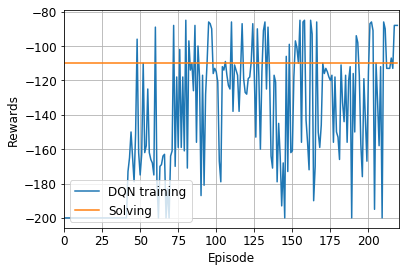

In [0]:
def train_dqn(episodes):

    """
    Train dqn model to interact with and learn from the environment
    """
    
    loss = []
    agent = DQN() 
  
    for episode in range(episodes):
        env.seed(episode)
        state = env.reset()
        state = np.reshape(state, (1, 2))
        score = 0
        max_steps = 200

        # Exploration is large in the beginning of training and then gradually reduced 
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 

        for i in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, (1, 2))
            score = score -1
            reward = agent.optimal_reward(next_state, state)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()

            # The episode is done when the agent reaches the goal or 200 steps
            if done: 
                print("episode: {}/{}, score: {}".format(episode, episodes, score))
                break
        env.close()
        loss.append(score)

        # Early stop 
        if np.average(loss[-10:]) >= -110:
            break

    agent.save_model(filename = 'MountainCar-v0-dqn.h5')
    return loss, res

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ep = 500
    res = []
    x = []
    loss, res = train_dqn(ep)

    ### Visualize the process of training dqn model
    plt.subplots(figsize= (6, 4))
    plt.plot(list(range(len(loss))), loss, label = 'DQN training')
    plt.plot(list(range(len(loss))), np.ones((len(loss), 1))* -110, label = 'Solving')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.legend(loc = 'lower left')
    plt.xlim(0, len(loss))
    plt.grid(True)
    plt.show()

In [0]:
def test_dqn(episode):

    """
    Valide dqn model with 100 trials. MountainCarContinuous-v0 defines "solving" 
    as getting average reward of 90.0 over 100 consecutive trials.
    """
  
    episodes = episode
    scores = []
    states = []

    for e in range(episodes):
        state = env.reset()
        score = 0
        while True:
            action = np.argmax(model.predict(np.array([state])))
            state, reward, done, _ = env.step(action)
            states.append(state)
            score += reward
            if done:
                scores.append(score)
                break
        env.close()
    return np.average(scores), states

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    model = models.load_model('MountainCar-v0-dqn.h5')
    ep = 100
    loss, states = test_dqn(ep)
    print('Average rewards in the last 100 episodes: {}'.format(loss))

Average rewards in the last 100 episodes: -105.67


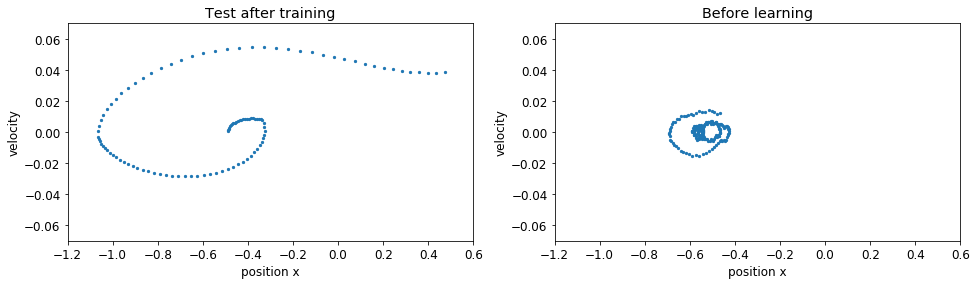

In [0]:
# Result visualization
fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (16, 4))

# After training
pos = [s[0] for s in states]
vel = [s[1] for s in states]
first_time_reach_goal = [i for i, p in enumerate(pos) if p >= 0.5][0]
ax0.scatter(pos[:first_time_reach_goal], vel[:first_time_reach_goal], s = 5)
ax0.set_title('Test after training')
ax0.set_xlabel('position x')
ax0.set_ylabel('velocity')
ax0.set_xlim(-1.2, 0.6)
ax0.set_ylim(-0.07, 0.07)
env.close()

# Before training
pos, vel = random_actions()
ax1.scatter(pos, vel, s = 5)
ax1.set_title('Before learning')
ax1.set_xlabel('position x')
ax1.set_ylabel('velocity')
ax1.set_xlim(-1.2, 0.6)
ax1.set_ylim(-0.07, 0.07)
env.close()

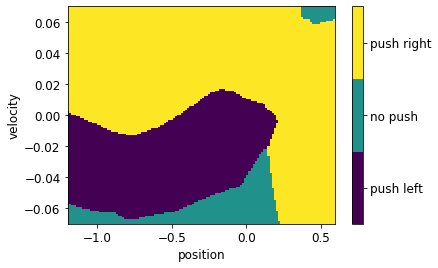

In [0]:
# Visualization of policy
poses = np.linspace(env.unwrapped.min_position, env.unwrapped.max_position, 128)
vels = np.linspace(-env.unwrapped.max_speed, env.unwrapped.max_speed, 128)
positions, velocities = np.meshgrid(poses, vels)

env = gym.make('MountainCar-v0')
model = models.load_model('MountainCar-v0-dqn.h5')

@np.vectorize
def decide(position, velocity):
    return np.argmax(model.predict(np.array([[position, velocity]])))
    
action_values = decide(positions, velocities)

fig, ax = plt.subplots()
c = ax.pcolormesh(positions, velocities, action_values)
ax.set_xlabel('position')
ax.set_ylabel('velocity')
cbar = fig.colorbar(c, ax = ax, boundaries = [-.5, .5, 1.5, 2.5], ticks = [0, 1, 2])
cbar.ax.set_yticklabels(['push left', 'no push', 'push right'])
fig.show()